In [3]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re
import ns
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc


sys.path.insert(1, '/fs/lustre/cita/claireshiye/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/fs/lustre/cita/claireshiye/projects/pulsar_offsets/'

3.5.2


In [ ]:
#from importlib import reload
#reload(pc)
Poff, Offset, Binoff, Nameoff, Clusoff = pc.readdata_freire('/fs/lustre/cita/claireshiye/projects/pulsar_offsets', 
                                                            spinflag=0,offsetflag=1)
print(np.max(Offset))
Offset=np.array(Offset); Binoff = np.array(Binoff)
Poff = np.array(Poff); Clusoff = np.array(Clusoff)
Nameoff = np.array(Nameoff)
#Offset = Offset[Poff<=30.]; Binoff = Binoff[Poff<=30]; Clusoff = Clusoff[Poff<=30]


data_gcmsp = pd.read_excel('/fs/lustre/cita/claireshiye/projects/pulsar_offsets/psrcatalog_numbers.xlsx',
                           names = ['name','rc','rhl','long','lat','dist','ntot','nbin','cc'],
                          skiprows = 1)
rc_psrcat = np.array(data_gcmsp['rc']); rhl_psrcat = np.array(data_gcmsp['rhl'])
CCst = np.array(data_gcmsp['cc'])
clusname = data_gcmsp['name']
clusno = []
for ii in range(len(clusname)):
    if str(clusname[ii])[0]=='N' or str(clusname[ii])[0]=='T':
        clusno.append(str(clusname[ii]).split()[-1])
    else:
        clusno.append(re.split('\)| ', str(clusname[ii]))[-2])
clusno = np.array(clusno)

Rcoff = []; Rhloff = []; CCs = []
for kk in range(len(Clusoff)):
    Rcoff.append(rc_psrcat[clusno==Clusoff[kk]][0])
    Rhloff.append(rhl_psrcat[clusno==Clusoff[kk]][0])
    CCs.append(CCst[clusno==Clusoff[kk]][0]) 
Rcoff = np.array(Rcoff); Rhloff = np.array(Rhloff)
CCs = np.array(CCs)

binoffrhl = (Offset/Rhloff)[Binoff==1]
sinoffrhl = (Offset/Rhloff)[Binoff==0]
print('bin', len(binoffrhl), 'sin', len(sinoffrhl))

binoffrc = (Offset/Rcoff)[Binoff==1]
sinoffrc = (Offset/Rcoff)[Binoff==0]

ccbinoffrhl = (Offset/Rhloff)[(Binoff==1) & (CCs==1)]
ccsinoffrhl = (Offset/Rhloff)[(Binoff==0) & (CCs==1)]

nonccbinoffrhl = (Offset/Rhloff)[(Binoff==1) & (CCs==0)]
nonccsinoffrhl = (Offset/Rhloff)[(Binoff==0) & (CCs==0)]

ccbinoffrc = (Offset/Rcoff)[(Binoff==1) & (CCs==1)]
ccsinoffrc = (Offset/Rcoff)[(Binoff==0) & (CCs==1)]

nonccbinoffrc = (Offset/Rcoff)[(Binoff==1) & (CCs==0)]
nonccsinoffrc = (Offset/Rcoff)[(Binoff==0) & (CCs==0)]

288
6.39
bin 76 sin 65


(0.09442698456897061, 45)

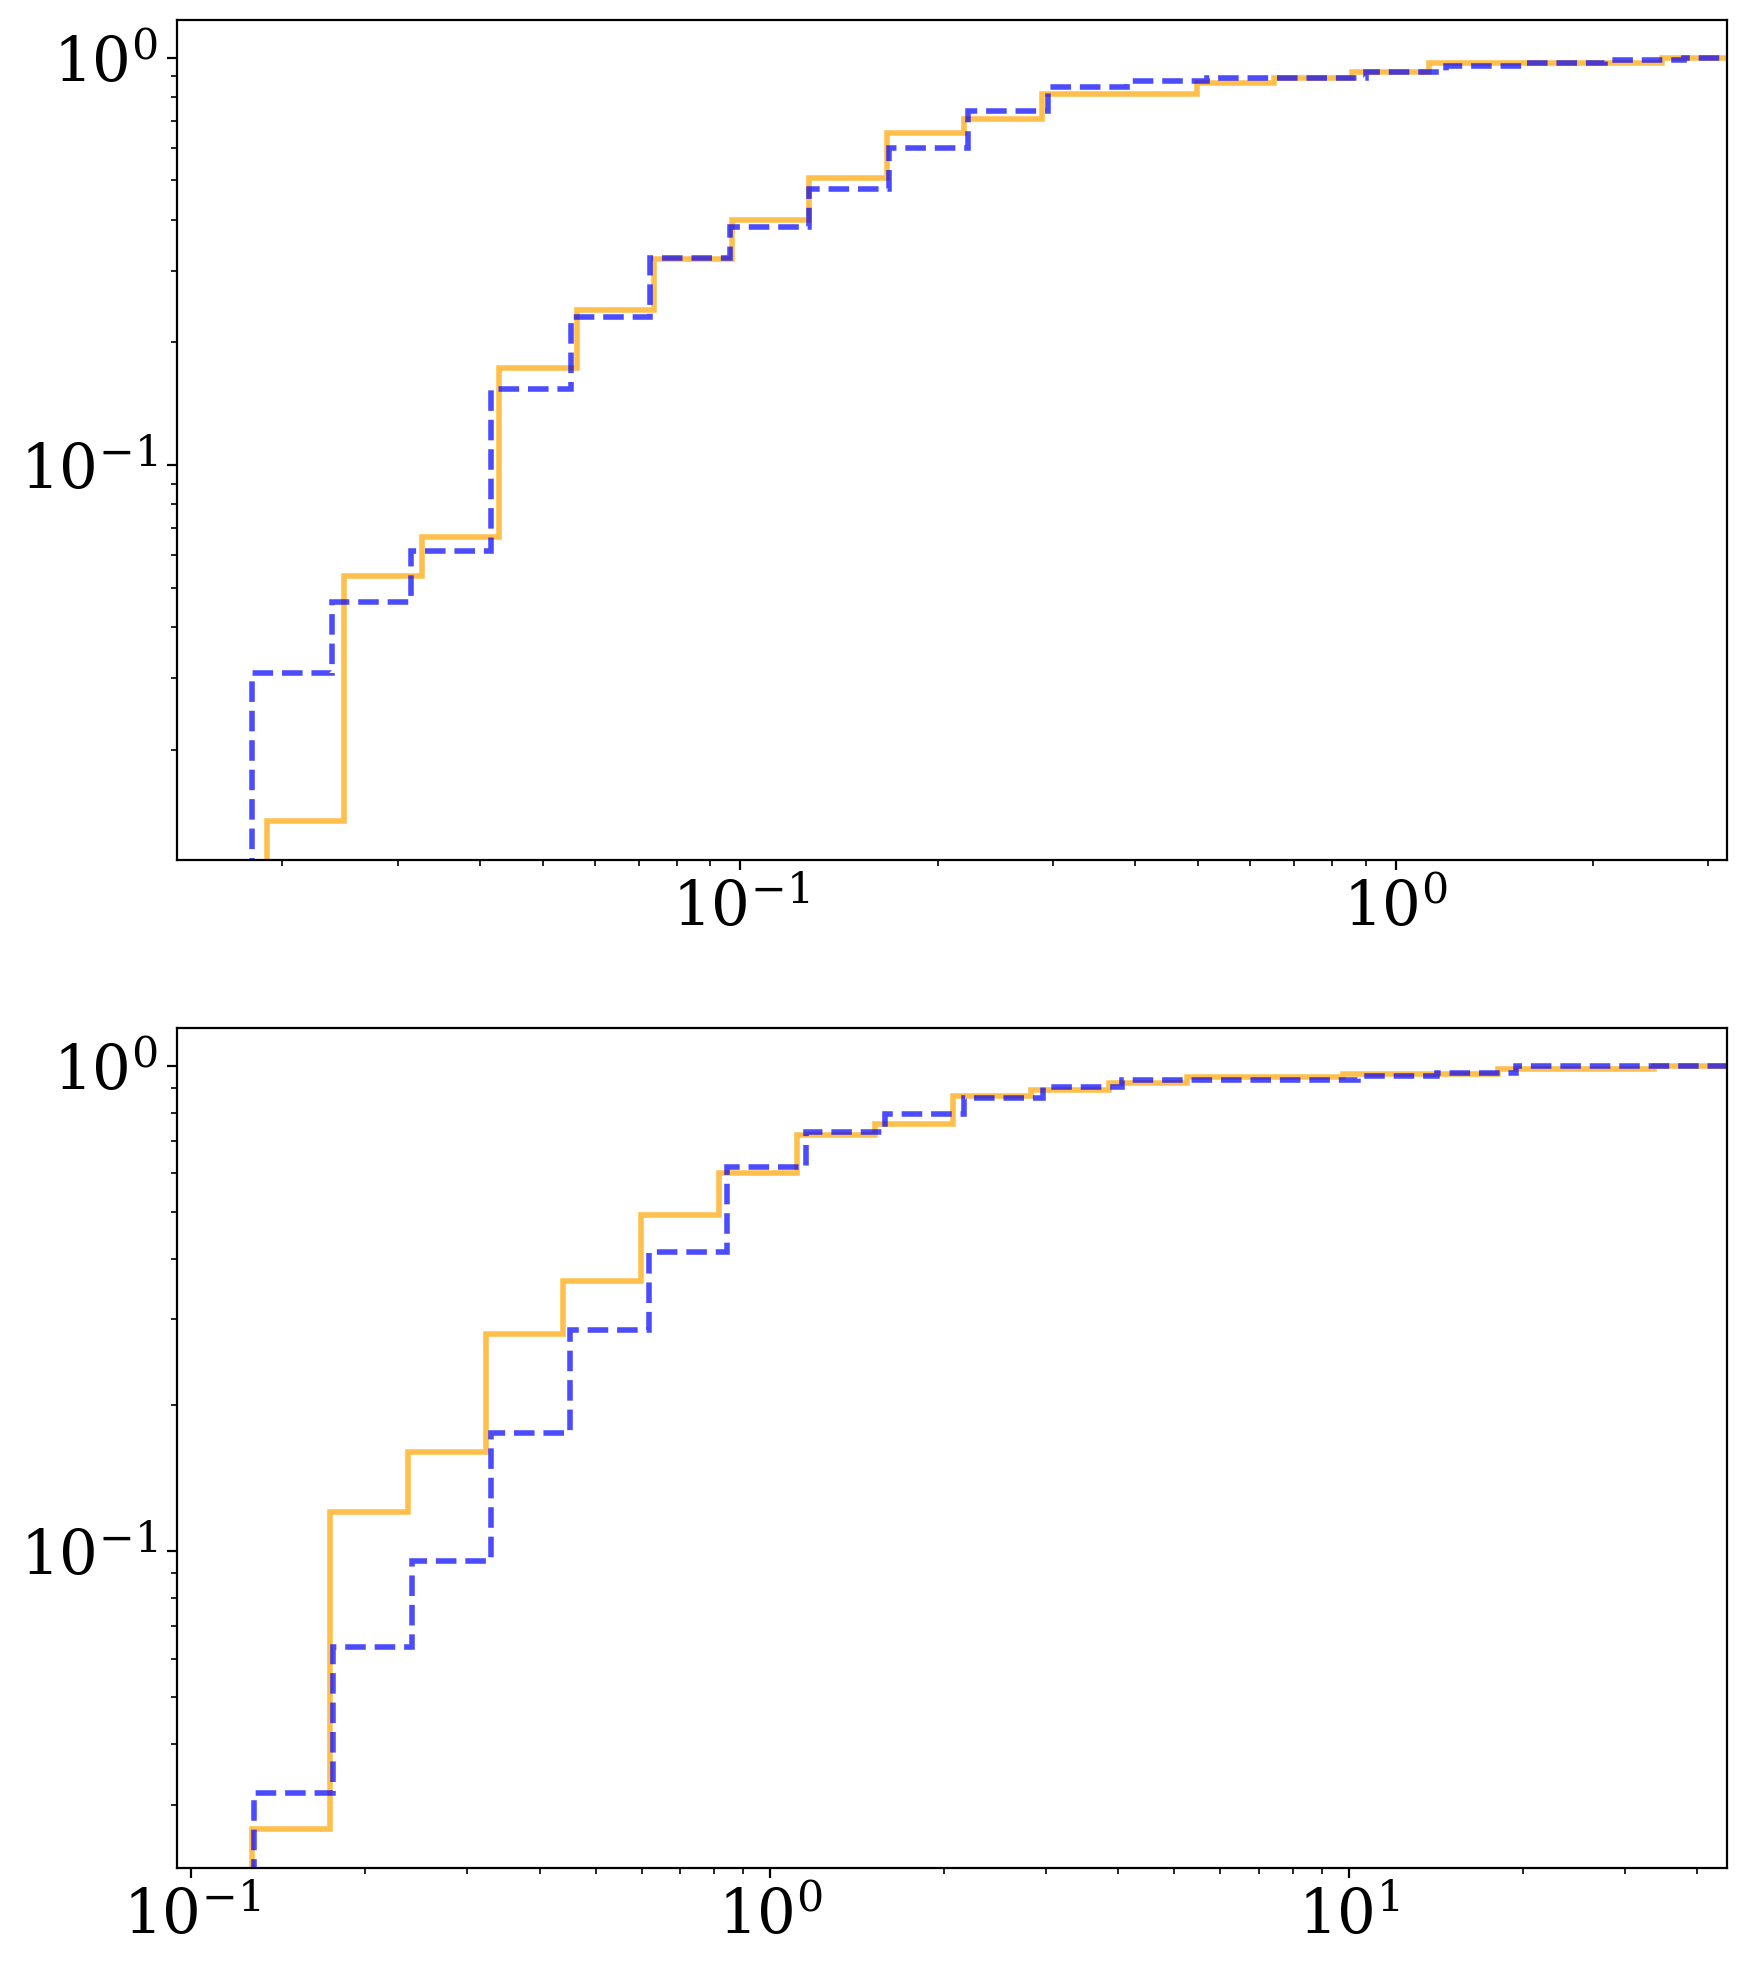

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(10,12))
axs[0].hist(binoffrhl, 
        bins = np.logspace(np.log10(np.min(binoffrhl)), np.log10(np.max(binoffrhl)), 20),
        cumulative=True, #weights = np.ones_like(binoffrhl)/float(len(binoffrhl)),
        density=True, #stacked=True,
        range=(0,np.max(sinoffrhl)),
        histtype='step', label = 'Observed bPSR', lw=2, color='orange', alpha=0.7)
axs[0].hist(sinoffrhl,
        bins = np.logspace(np.log10(np.min(sinoffrhl)), np.log10(np.max(sinoffrhl)), 20),
        cumulative=True, #weights = np.ones_like(sinoffrhl)/float(len(sinoffrhl)),
        density=True, #stacked=True,
        range=(0,np.max(sinoffrhl)),
        histtype='step', label = 'Observed sPSR', lw=2, ls='--', color='blue', alpha=0.7)

axs[1].hist(binoffrc, 
        bins = np.logspace(np.log10(np.min(binoffrc)), np.log10(np.max(binoffrc)), 20),
        cumulative=True, #weights = np.ones_like(binoffrc)/float(len(binoffrc)),
        density=True, #stacked=True,
        range=(0,np.max(sinoffrc)),
        histtype='step', label = 'Observed bPSR', lw=2, color='orange', alpha=0.7)
axs[1].hist(sinoffrc,
        bins = np.logspace(np.log10(np.min(sinoffrc)), np.log10(np.max(sinoffrc)), 20),
        cumulative=True, #weights = np.ones_like(sinoffrc)/float(len(sinoffrc)),
        density=True, #stacked=True,
        range=(0,np.max(sinoffrc)),
        histtype='step', label = 'Observed sPSR', lw=2, ls='--', color='blue', alpha=0.7)


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(xmax=3.2)

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim(xmax=45)